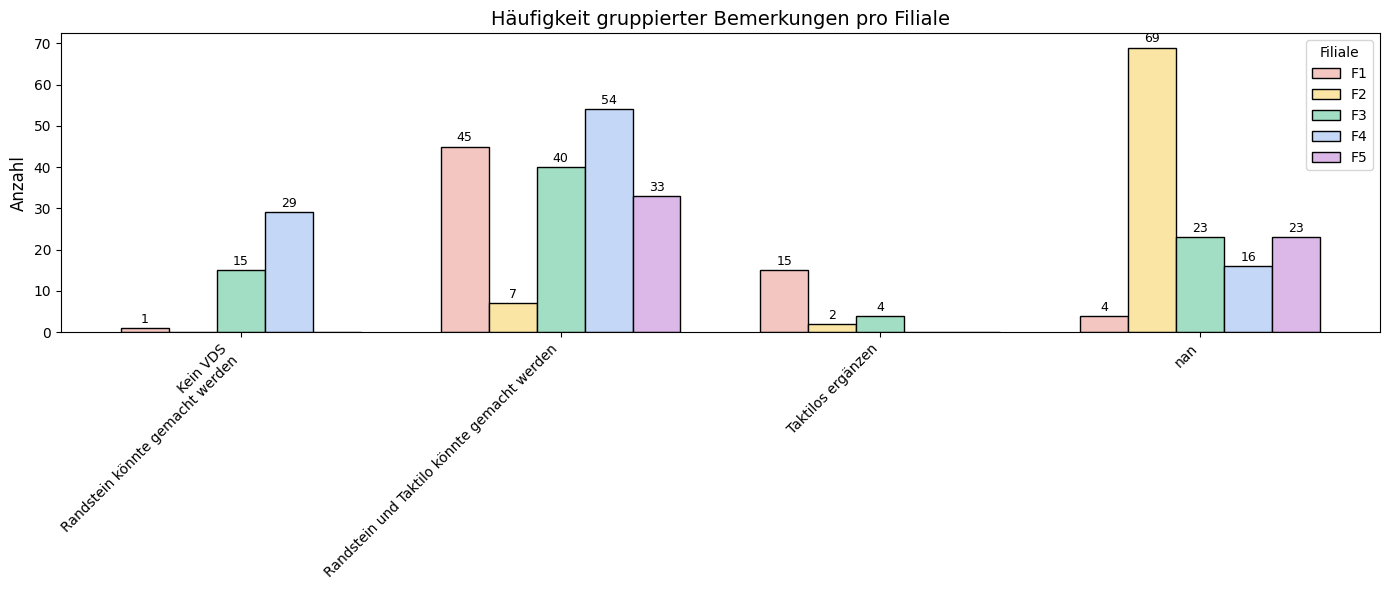

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rapidfuzz import process, fuzz

# --- Daten einlesen ---
df = pd.read_csv("ASTRA-Bushaltestellen.csv", delimiter=';')

# --- Whitespace bereinigen ---
df["Bemerkungen"] = df["Bemerkungen"].astype(str).str.strip()
df["Filiale"] = df["Filiale"].astype(str).str.strip()

# --- Nur sinnvolle Bemerkungen ---
df = df[df["Bemerkungen"] != ""]

# --- Cluster ähnliche Bemerkungen mit rapidfuzz (Option 2) ---
def cluster_bemerkungen(bemerkungen, threshold=85):
    clusters = {}
    labels = []
    for bem in bemerkungen:
        if not labels:
            labels.append(bem)
            clusters[bem] = [bem]
        else:
            match, score, idx = process.extractOne(bem, labels, scorer=fuzz.token_sort_ratio)
            if score >= threshold:
                clusters[labels[idx]].append(bem)
            else:
                labels.append(bem)
                clusters[bem] = [bem]
    return clusters, labels

alle_bemerkungen = df["Bemerkungen"].unique()
clusters, labels = cluster_bemerkungen(alle_bemerkungen, threshold=85)

# --- Map Original-Bemerkung auf Cluster-Label ---
mapping = {}
for label, group in clusters.items():
    for item in group:
        mapping[item] = label

df["Bemerkung_cluster"] = df["Bemerkungen"].map(mapping)

# --- Häufige Cluster filtern (>10) ---
häufigkeiten = df["Bemerkung_cluster"].value_counts()
relevante = häufigkeiten[häufigkeiten > 10].index
df_filtered = df[df["Bemerkung_cluster"].isin(relevante)]

# --- Gruppieren nach Cluster & Filiale ---
gruppe = df_filtered.groupby(["Bemerkung_cluster", "Filiale"]).size().unstack(fill_value=0)

# --- Farben ---
farben_gesamt = {
    "F1": "#F4C6C2",
    "F2": "#FAE5A4",
    "F3": "#A2DEC3",
    "F4": "#C4D7F7",
    "F5": "#DBB8E8"
}

# --- Plot ---
bemerkungen = gruppe.index
filialen = gruppe.columns
x = np.arange(len(bemerkungen))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 6))

for i, filiale in enumerate(filialen):
    werte = gruppe[filiale]
    ax.bar(x + i * width, werte, width=width, label=filiale,
           color=farben_gesamt.get(filiale, "gray"), edgecolor="black")
    
    for j, val in enumerate(werte):
        if val > 0:
            ax.text(x[j] + i * width, val + 0.5, str(val),
                    ha='center', va='bottom', fontsize=9)

ax.set_xticks(x + width * (len(filialen)-1)/2)
ax.set_xticklabels(bemerkungen, rotation=45, ha='right', fontsize=10)
ax.set_ylabel("Anzahl", fontsize=12)
ax.set_title("Häufigkeit gruppierter Bemerkungen pro Filiale", fontsize=14)
ax.legend(title="Filiale")

plt.tight_layout()
plt.show()

# --- Funktion zum Suchen in den Bemerkungen ---
def suche_in_bemerkungen(suchbegriff):
    suchbegriff_lower = suchbegriff.lower()
    treffer = df[df["Bemerkungen"].str.lower().str.contains(suchbegriff_lower)]
    if treffer.empty:
        print(f"Keine Bemerkungen mit '{suchbegriff}' gefunden.")
    else:
        print(f"Gefundene Objekte mit Bemerkungen, die '{suchbegriff}' enthalten:")
        display(treffer[["Filiale", "Bemerkungen"]])  # ggf. weitere Spalten anzeigen

# --- Beispielaufruf ---
# suche_in_bemerkungen("Taktilo")

def fuzzy_suche_in_bemerkungen(suchbegriff, threshold=30, max_matches=10):
    """
    Suche fuzzy ähnliche Bemerkungen und zeige zugehörige Objekte.

    suchbegriff: String, wonach gesucht wird
    threshold: Minimaler Ähnlichkeitswert (0-100)
    max_matches: Maximale Anzahl der ausgegebenen ähnlichen Bemerkungen
    """
    suchbegriff_lower = suchbegriff.lower()
    
    # Alle einzigartigen Bemerkungen (originale Texte)
    unique_bemerkungen = df["Bemerkungen"].unique()
    
    # Fuzzy-Matches: suche ähnliche Bemerkungen zum Suchbegriff
    matches = process.extract(suchbegriff_lower, unique_bemerkungen, scorer=fuzz.token_sort_ratio, limit=max_matches)
    
    # Filter Matches nach threshold
    gute_matches = [match for match, score, _ in matches if score >= threshold]
    
    if not gute_matches:
        print(f"Keine ähnlichen Bemerkungen mit '{suchbegriff}' gefunden (Threshold={threshold}%).")
        return
    
    # Filter DataFrame nach Bemerkungen, die in den guten Matches sind
    treffer = df[df["Bemerkungen"].isin(gute_matches)]
    
    print(f"Gefundene Bemerkungen ähnlich zu '{suchbegriff}' (mind. {threshold}% Ähnlichkeit):")
    for bem in gute_matches:
        print(f"  - {bem}")
    print("\nDetails zu passenden Objekten:")
    display(treffer[["Filiale", "Bemerkungen"]])  # weitere Spalten je nach Bedarf hinzufügen

# Beispielaufruf
# fuzzy_suche_in_bemerkungen("Taktilo")


In [12]:
fuzzy_suche_in_bemerkungen("Taktilo")

Gefundene Bemerkungen ähnlich zu 'Taktilo' (mind. 30% Ähnlichkeit):
  - Taktilo ergänzen
  - Taktilos ergänzen

Details zu passenden Objekten:


,Filiale,Bemerkungen
28,F1,Taktilos ergänzen
29,F1,Taktilos ergänzen
32,F1,Taktilos ergänzen
33,F1,Taktilos ergänzen
57,F1,Taktilo ergänzen
58,F1,Taktilo ergänzen
72,F1,Taktilo ergänzen
74,F1,Taktilo ergänzen
75,F1,Taktilo ergänzen
76,F1,Taktilo ergänzen
